## Hyperparameter tuning - Random Forest , XGBoost, LightGBM

In [1]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install lightgbm

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install tqdm

Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install pandas numpy scikit-learn tensorflow matplotlib keras

Note: you may need to restart the kernel to use updated packages.


In [5]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time # To time operations

# --- ML Models ---
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
import lightgbm as lgb

# --- Preprocessing & Splitting ---
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.preprocessing import MinMaxScaler

# --- Metrics & Utilities ---
from sklearn.metrics import mean_squared_error, r2_score
from tqdm import tqdm # Keep progress bar support if needed (though GridSearchCV has its own)
from sklearn.exceptions import ConvergenceWarning
import warnings

# Filter convergence warnings for cleaner output if desired
# warnings.filterwarnings("ignore", category=ConvergenceWarning)
# warnings.filterwarnings("ignore", category=FutureWarning)



--- Tuning RandomForestRegressor ---
Fitting 5 folds for each of 48 candidates, totalling 240 fits
Finished tuning RandomForestRegressor in 63.15 seconds
Best Parameters: {'max_depth': 10, 'max_features': 1.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Best CV R2 Score: 0.998477

--- Tuning XGBRegressor ---
Fitting 5 folds for each of 108 candidates, totalling 540 fits
Finished tuning XGBRegressor in 19.01 seconds
Best Parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.05, 'max_depth': 7, 'n_estimators': 200, 'subsample': 0.9}
Best CV R2 Score: 0.999006

--- Tuning LGBMRegressor ---
Fitting 5 folds for each of 324 candidates, totalling 1620 fits
Finished tuning LGBMRegressor in 26.32 seconds
Best Parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200, 'num_leaves': 20, 'subsample': 0.7}
Best CV R2 Score: 0.979579

--- Final Evaluation on Test Set ---
RandomForest → R2: 0.9980, MSE: 0.0260, Time: 0.0167s
XGBoost → 

c:\Users\user\anaconda3\envs\hydrogen\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


              Best_CV_R2   Test_R2  Test_MSE  Predict_Time_s
RandomForest    0.998477  0.998045  0.025952        0.016652
XGBoost         0.999006  0.996017  0.052873        0.016074
LightGBM        0.979579  0.994836  0.068559        0.011342


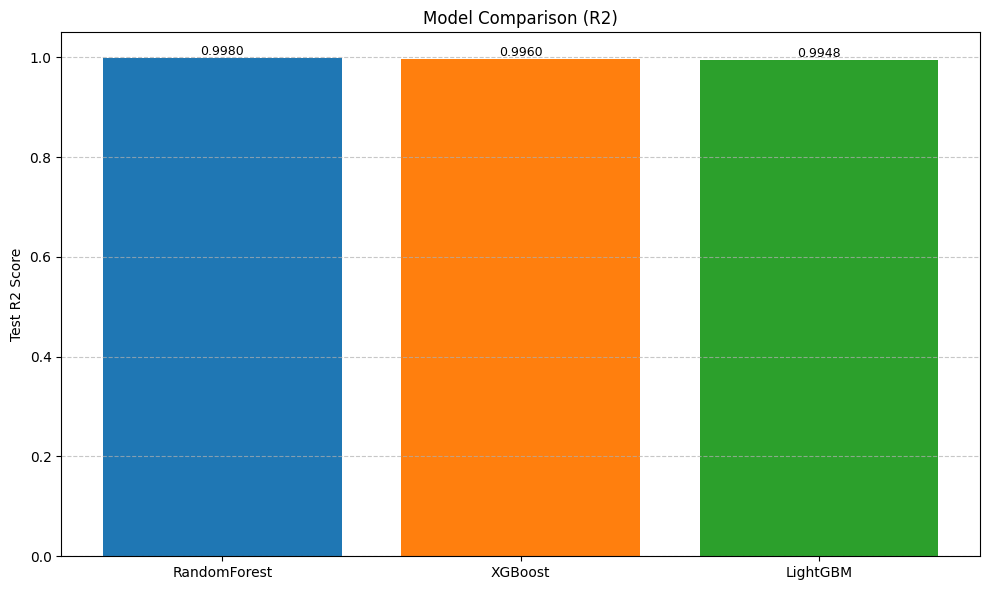


Script finished.


In [6]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

# --- ML Models ---
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
import lightgbm as lgb

# --- Preprocessing & Splitting ---
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.preprocessing import MinMaxScaler

# --- Metrics & Utilities ---
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.exceptions import ConvergenceWarning
import warnings

# warnings.filterwarnings("ignore", category=ConvergenceWarning)

# Reproducibility
seed = 42
os.environ['PYTHONHASHSEED'] = str(seed)
random.seed(seed)
np.random.seed(seed)


# --- Data Loading ---
def load_and_preprocess_data(file_path, test_size=0.2, random_state=42):
    """Loads CSV data, scales features, and splits into train/test."""
    try:
        df = pd.read_csv(file_path)
    except FileNotFoundError:
        raise FileNotFoundError(f"File not found at {file_path}. Please ensure the file is in your project folder.")

    if 'efficiency' not in df.columns:
        raise ValueError("Column 'efficiency' not found in the dataset.")

    X = df.drop('efficiency', axis=1)
    y = df['efficiency']

    # Optional: Handle missing/infinite values
    if X.isnull().sum().sum() > 0 or y.isnull().sum() > 0:
        print("Warning: NaN values found. Please clean your data.")
    if np.isinf(X.values).sum() > 0 or np.isinf(y.values).sum() > 0:
        print("Warning: Infinite values found. Please clean your data.")

    scaler = MinMaxScaler(feature_range=(-1, 1))
    X_scaled = scaler.fit_transform(X)

    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, y, test_size=test_size, random_state=random_state
    )

    return (X_train, y_train.to_numpy()), (X_test, y_test.to_numpy()), scaler


# --- GridSearchCV Tuning ---
def tune_model_gridsearch(model, param_grid, X_train, y_train, n_splits=5, scoring='r2'):
    model_name = model.__class__.__name__
    print(f"\n--- Tuning {model_name} ---")
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=seed)

    fit_params = {}
    if isinstance(model, lgb.LGBMRegressor):
        fit_params['callbacks'] = [lgb.log_evaluation(period=0)]

    start_time = time.time()
    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        scoring=scoring,
        cv=kf,
        n_jobs=-1,
        verbose=1
    )

    grid_search.fit(X_train, y_train, **fit_params)
    runtime = time.time() - start_time

    print(f"Finished tuning {model_name} in {runtime:.2f} seconds")
    print("Best Parameters:", grid_search.best_params_)
    print(f"Best CV R2 Score: {grid_search.best_score_:.6f}")

    return grid_search.best_estimator_, grid_search.best_score_


# --- Main ---
def main():
    # CSV file must be in the same folder as this script
    file_path = r'C:\Users\user\OneDrive\Desktop\sneha\PROJECT\dataset\original\data_set.csv'  

    # Model flags
    run_random_forest = True
    run_xgboost = True
    run_lightgbm = True

    # Hyperparameter grids
    rf_param_grid = {
        'n_estimators': [100, 200],
        'max_depth': [10, 20, None],
        'min_samples_split': [2, 5],
        'min_samples_leaf': [1, 3],
        'max_features': ['sqrt', 1.0]
    }

    xgb_param_grid = {
        'n_estimators': [100, 200],
        'max_depth': [3, 5, 7],
        'learning_rate': [0.05, 0.1],
        'subsample': [0.7, 0.9, 1.0],
        'colsample_bytree': [0.7, 0.9, 1.0]
    }

    lgbm_param_grid = {
        'n_estimators': [100, 200],
        'max_depth': [5, 10, -1],
        'learning_rate': [0.05, 0.1],
        'num_leaves': [20, 31, 40],
        'subsample': [0.7, 0.9, 1.0],
        'colsample_bytree': [0.7, 0.9, 1.0]
    }

    try:
        (X_train, y_train), (X_test, y_test), scaler = load_and_preprocess_data(file_path)
    except Exception as e:
        print("Error:", e)
        return

    best_models = {}
    cv_scores = {}
    test_results = {}

    if run_random_forest:
        rf_model = RandomForestRegressor(random_state=seed, n_jobs=1)
        best_rf, rf_score = tune_model_gridsearch(rf_model, rf_param_grid, X_train, y_train)
        best_models['RandomForest'] = best_rf
        cv_scores['RandomForest'] = rf_score

    if run_xgboost:
        xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=seed, verbosity=0, n_jobs=1)
        best_xgb, xgb_score = tune_model_gridsearch(xgb_model, xgb_param_grid, X_train, y_train)
        best_models['XGBoost'] = best_xgb
        cv_scores['XGBoost'] = xgb_score

    if run_lightgbm:
        lgbm_model = lgb.LGBMRegressor(objective='regression', metric='rmse', random_state=seed, verbosity=-1, n_jobs=1)
        best_lgbm, lgbm_score = tune_model_gridsearch(lgbm_model, lgbm_param_grid, X_train, y_train)
        best_models['LightGBM'] = best_lgbm
        cv_scores['LightGBM'] = lgbm_score

    print("\n--- Final Evaluation on Test Set ---")
    for name, model in best_models.items():
        try:
            start = time.time()
            y_pred = model.predict(X_test)
            elapsed = time.time() - start

            test_r2 = r2_score(y_test, y_pred)
            test_mse = mean_squared_error(y_test, y_pred)
            test_results[name] = {
                'Best_CV_R2': cv_scores[name],
                'Test_R2': test_r2,
                'Test_MSE': test_mse,
                'Predict_Time_s': elapsed
            }

            print(f"{name} → R2: {test_r2:.4f}, MSE: {test_mse:.4f}, Time: {elapsed:.4f}s")

        except Exception as e:
            print(f"{name} failed: {e}")
            test_results[name] = {
                'Best_CV_R2': cv_scores.get(name, np.nan),
                'Test_R2': np.nan,
                'Test_MSE': np.nan,
                'Predict_Time_s': np.nan
            }

    # --- Plotting ---
    if test_results:
        results_df = pd.DataFrame(test_results).T
        results_df = results_df[['Best_CV_R2', 'Test_R2', 'Test_MSE', 'Predict_Time_s']]
        print("\n--- Summary ---")
        print(results_df.sort_values(by='Test_R2', ascending=False))

        plt.figure(figsize=(10, 6))
        bars = plt.bar(results_df.index, results_df['Test_R2'].fillna(-1), color=['#1f77b4', '#ff7f0e', '#2ca02c'])
        plt.ylabel("Test R2 Score")
        plt.title("Model Comparison (R2)")
        plt.ylim([0, 1.05])
        for bar in bars:
            height = bar.get_height()
            if height >= 0:
                plt.text(bar.get_x() + bar.get_width()/2.0, height, f'{height:.4f}', ha='center', va='bottom', fontsize=9)
        plt.tight_layout()
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.show()

    print("\nScript finished.")
    return best_models, test_results, scaler


# --- Run ---
if __name__ == "__main__":
    tuned_models, final_results, data_scaler = main()
